In [ ]:
!pip install sovai[full]

## Causal Discovery

In [ ]:
Looks good, but you should probably read the research paper to know what is going on here. ###  
There are this range of additional things you should be able to do https://lingam.readthedocs.io/en/stable/tutorial/var.html

It might be necessary for you to get someone to help you speed up this model. 
You really need to create the dataframes for it to become tßruly useful, and you need the speedups. 
https://lingam.readthedocs.io/en/stable/tutorial/var.html

Bootstrapping a causal discovery algorithm and returning a summary graph constructed by a voting scheme is a feature of the TETRAD project 

Could be helpful https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_discovery/tigramite_tutorial_jpcmciplus.ipynb

There is some very interesting results here actaulluy: PCMCI+ https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_discovery/tigramite_tutorial_pcmciplus.ipynb

Interesting, Dynotears from Time Series Modelling.. https://github.com/mckinsey/causalnex/blob/6a361d3a5f79418aa60ec89222c1b9979ce3f121/causalnex/structure/dynotears.py#L46

https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py (interesting)

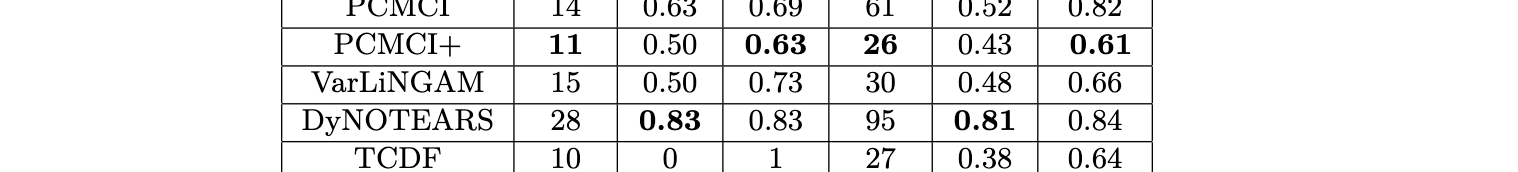 together seem to be performing pretty much wheen otehr one bad

In [ ]:
PCMCI+, Varlingam, Dynotears

In [3]:
import sovai as sov
import pandas as pd
# Set the option to display all columns
pd.set_option('display.max_columns', None)

sov.token_auth(token="visit https://sov.ai/profile for your token")
# And then continue working with get some data from API and manipulating them

/breakout/median
Requesting URL: https://fastapi-sovai-y7o724zyfq-uc.a.run.app/breakout/median with params: None
Response Status: 200
Response Content-Type: application/json
tickers is None
None
tickers is: 
All ticker Initialized
https://s3.wasabisys.com/sovai-breakout-price/frames/df_test_summary_median.park?AWSAccessKeyId=KI07G4DK9XP5EC0NH1VU&Signature=icAvVYT1DPmjkkd3wyYkhJtJINo%3D&Expires=1709566540  (download link)
File is up-to-date, no need to download.


True

#### Processed Dataset

In [4]:
df_accounting = pd.read_parquet("sample_accounting.parquet")

In [5]:
import lingam
import pandas as pd

# Assuming df_accounting is your DataFrame with MultiIndex (ticker, date)

def remove_ticks(df_accounting, feature):
    # Step 1: Group by 'ticker' and calculate the mean of 'total_revenue'
    ticker_revenue_mean = df_accounting.groupby('ticker')[feature].mean()
    
    # Step 2: Find tickers where the mean revenue is zero
    tickers_to_remove = ticker_revenue_mean[ticker_revenue_mean == 0].index
    
    # Step 3: Filter out these tickers from the original DataFrame
    df_filtered = df_accounting[~df_accounting.index.get_level_values('ticker').isin(tickers_to_remove)]
    return df_filtered

def singular_feature(df_accounting, feature):
    df_filtered = remove_ticks(df_accounting, feature)
    
    df_total_revenue = df_filtered.reset_index()[['date', 'ticker', feature]]
    
    df_pivoted = df_total_revenue.reset_index().pivot(index='date', columns='ticker', values=feature)
    
    df_pivoted = df_pivoted.dropna(axis=1, how="all")
    
    df_pivoted = df_pivoted.rank(pct=True)

    
    return df_pivoted

def variable_improvement(df_accounting, variable):

    df_pivoted = singular_feature(df_accounting, variable)
    
    df_pivoted = df_pivoted.dropna(axis=1, subset=[df_pivoted.index[-1]])
    
    row_means = df_pivoted.mean(axis=1)
    
    df_pivoted = df_pivoted.dropna(axis=0, how='all')
    
    df_pivoted = df_pivoted.T.fillna(row_means).T # replace na with row's mean
    
    df_pivoted = df_pivoted.resample('M').last() ### you should probably add this back, because speeds up. (keep this as is, worse results otherwise)
    return df_pivoted 


## this is only lags=1

def causal_model(df_accounting, variable, lags):
    model = lingam.VARLiNGAM(lags=lags)
    
    process_df = variable_improvement(df_accounting, variable)
    
    model.fit(process_df)
    
    causal_order = model.causal_order_

    org_labels = process_df.columns.to_list()
    
    order_labels = process_df.iloc[:,causal_order].columns.to_list()

    adjacency_matrices = model.adjacency_matrices_

    return causal_order, order_labels, org_labels, adjacency_matrices, model 

causal_order, order_labels, org_labels, adjacency_matrices, model  = causal_model(df_accounting, "total_revenue", lags=1)


In [6]:
process_df = variable_improvement(df_accounting, "total_revenue")

In [7]:
process_df.shape

(325, 48)

In [ ]:
## You should probably use bootstrapping for the effect to matter, but maybe you could do it without?
model = lingam.VARLiNGAM()
result = model.bootstrap(process_df, n_sampling=150)

In [ ]:
result

In [ ]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.3, split_by_causal_effect_sign=True)

In [ ]:
print_causal_directions(cdc, 100, labels=labels)

In [15]:
dim_1_labels = [feat + "(t0)" for feat in org_labels]
dim_2_labels = [feat + "(t-1)" for feat in org_labels]

dot = make_dot(np.hstack(adjacency_matrices), ignore_shape=True, lower_limit=0.20, labels=dim_1_labels + dim_2_labels)

In [18]:
order_labels

['IMNN',
 'TG',
 'OBLG',
 'BWA',
 'CZFS',
 'RDN',
 'ACGL',
 'HOPE',
 'ENS',
 'NECB',
 'GAU',
 'XNCR',
 'FORTY',
 'EXR',
 'GLOB',
 'PSTL',
 'DVN',
 'TSN',
 'MPWR',
 'SKYW',
 'NPWR',
 'APP',
 'PCTI',
 'ALTR',
 'OBDE',
 'VAC',
 'EVRI',
 'VLN',
 'VERV',
 'VBTX',
 'GROV',
 'ATAI',
 'UTRS',
 'CCCC',
 'CYN',
 'DXYN',
 'FNCH',
 'INBX',
 'LUMO',
 'FKWL',
 'DFIN',
 'HEP',
 'HNRG',
 'ROIC',
 'MDIA',
 'MFIC',
 'ISTR',
 'LKCO']

In [16]:

dot.format = 'svg'
dot.render('test')


'test.svg'

In [17]:
    # Assuming 'dot' is your Graphviz Digraph object
    dot_string = dot.source
    
    # Parse the DOT string into a pydot graph
    pydot_graph = pydot.graph_from_dot_data(dot_string)[0]
    
    # Convert pydot graph to NetworkX graph
    nx_graph = nx.nx_pydot.from_pydot(pydot_graph)
    
    # Assuming 'nx_graph' is your existing NetworkX graph
    # You can load or create your NetworkX graph here
    
    # Create a PyVis network
    net = Network(notebook=True)
    
    
    # Adjust physics settings for faster stabilization
    net.options.physics.enabled = True
    net.options.physics.solver = 'forceAtlas2Based'
    
    # Fine-tune forceAtlas2Based settings for better layout quality
    net.options.physics.forceAtlas2Based.theta = 0.5  # Adjust the Barnes-Hut approximation
    net.options.physics.forceAtlas2Based.gravitationalConstant = -50  # Decrease for less repulsion
    net.options.physics.forceAtlas2Based.centralGravity = 0.01  # Lower value for less influence of central gravity
    net.options.physics.forceAtlas2Based.springLength = 100  # Increase for larger distance between nodes
    net.options.physics.forceAtlas2Based.springConstant = 0.08  # Increase for stronger springs
    net.options.physics.forceAtlas2Based.damping = 0.4  # Increase for faster stabilization
    
    net.from_nx(nx_graph)
    
    # Show the interactive graph in the notebook
    net.show('graph.html')

graph.html


In [10]:
from lingam.utils import make_dot, print_causal_directions, print_dagc
import pydot
from graphviz import Digraph
import networkx as nx
from pyvis.network import Network

def network():
    # Does create nice ones, but other model
    dot = make_dot(adjacent_one, ignore_shape=True, lower_limit=0.20, labels=labels)
    
    dot.format = 'svg'
    dot.render('test')
    
    # Assuming 'dot' is your Graphviz Digraph object
    dot_string = dot.source
    
    # Parse the DOT string into a pydot graph
    pydot_graph = pydot.graph_from_dot_data(dot_string)[0]
    
    # Convert pydot graph to NetworkX graph
    nx_graph = nx.nx_pydot.from_pydot(pydot_graph)
    
    # Assuming 'nx_graph' is your existing NetworkX graph
    # You can load or create your NetworkX graph here
    
    # Create a PyVis network
    net = Network(notebook=True)
    
    
    # Adjust physics settings for faster stabilization
    net.options.physics.enabled = True
    net.options.physics.solver = 'forceAtlas2Based'
    
    # Fine-tune forceAtlas2Based settings for better layout quality
    net.options.physics.forceAtlas2Based.theta = 0.5  # Adjust the Barnes-Hut approximation
    net.options.physics.forceAtlas2Based.gravitationalConstant = -50  # Decrease for less repulsion
    net.options.physics.forceAtlas2Based.centralGravity = 0.01  # Lower value for less influence of central gravity
    net.options.physics.forceAtlas2Based.springLength = 100  # Increase for larger distance between nodes
    net.options.physics.forceAtlas2Based.springConstant = 0.08  # Increase for stronger springs
    net.options.physics.forceAtlas2Based.damping = 0.4  # Increase for faster stabilization
    
    net.from_nx(nx_graph)
    
    # Show the interactive graph in the notebook
    net.show('graph.html')



In [11]:
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA

def cluster():
    heat_df = pd.DataFrame(adjacency_matrix[0], columns=labels, index=labels)
    
    scaler = StandardScaler()
    heat_df_scaled = pd.DataFrame(scaler.fit_transform(heat_df), columns=heat_df.columns, index=heat_df.index)
    
    # Assuming 'heat_df' is your DataFrame
    
    # Perform PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(heat_df)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    
    # Calculate the sum of each row in heat_df for the marker sizes
    marker_sizes = np.log(1 + heat_df.abs().sum())
    
    # Create a scatter plot with Plotly
    # Use size_max to adjust the maximum marker size
    fig = px.scatter(principalDf, x='PC1', y='PC2', text=heat_df.index, size=marker_sizes, size_max=30)  # Adjust size_max as needed
    
    # Adjust text size
    for trace in fig.data:
        trace.textfont.size = 10
    
    # Add different colors to the markers
    fig.update_traces(marker=dict(color=marker_sizes, colorbar=dict(title="Marker Size"),
                                  colorscale='Viridis'),
                      selector=dict(mode='markers+text'))
    
    # Set graph layout range between -0.5 and 0.5 for both axes
    fig.update_xaxes(range=[-0.5, 0.5])
    fig.update_yaxes(range=[-0.5, 0.5])
    
    # Show the plot
    fig.show()


In [ ]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime
import plotly.figure_factory as ff

# Function to create correlation heatmap
import scipy.cluster.hierarchy as sch

def corr_map(df_wide):
    # Calculate the correlation matrix

    # dfc = df_wide.copy()

    
    dfc = df_wide.corr()

    # dfc = 1- dfc

    # Perform hierarchical clustering
    linkage = sch.linkage(sch.distance.pdist(dfc), method='single')

    # Get the order of the dendrogram leaves
    dendro = sch.dendrogram(linkage, no_plot=True)
    order = dendro['leaves']

    # Reorder the correlation matrix
    dfc = dfc.iloc[order, order]

    # dfc = dfc.iloc[::-1]  # Reverse the order of rows

    # dfc = dfc.iloc[::-1, ::-1]
    
    z = dfc.values
    z_text = [[str(round(y, 2)) for y in x] for x in z]

    # Create the heatmap
    fig = ff.create_annotated_heatmap(
        z, 
        x=dfc.columns.tolist(), 
        y=dfc.columns.tolist(), 
        annotation_text=z_text, 
        colorscale='Blues',
        xgap=3, 
        ygap=2
    )

    # Set the height of the figure
    fig.update_layout(height=1400)

    return fig

## this one slow with that long one.

def connectedness()
    p_values = model.get_error_independence_p_values()
    
    # p_values = 1-p_values
    
    p_values_frame = pd.DataFrame(p_values, columns = df_pivoted.columns, index=df_pivoted.columns)
    
    ## measures how causally connected (TSN) is not connected to these features.
    return p_values_frame.abs().sum().sort_values()

def correlation():
    return corr_map(p_values_frame)


causal = sov.CausalDiscovery(df_accounting)

causal_order, labels, adjacency_matrix, model  = causal.model("total_revenue")

causal.network() ## should use labels, adjacent_one, please add warning message if causal.model should be run first.

causal.cluster() ## should use labels, adjacent_one, please add warning message if causal.model should be run first.

causal.connectedness()

causal.correlation()



In [8]:
df_accounting = sov.data("accounting/monthly")

/accounting/monthly
Requesting URL: https://fastapi-sovai-y7o724zyfq-uc.a.run.app/accounting/monthly with params: None
Response Status: 200
Response Content-Type: application/json
tickers is None
None
tickers is: 
All ticker Initialized
https://s3.wasabisys.com/sovai-accounting/processed/accounting_monthly_interpolated.parq?AWSAccessKeyId=KI07G4DK9XP5EC0NH1VU&Signature=8iPAmoE3EDRv9mS%2B9g60bOaWPjk%3D&Expires=1706733046  (download link)


In [11]:
df_accounting.shape

(1762124, 100)